In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-11-2022)' )

loaded gammapy version: 1.0 
Supposed to be 1.0 (21-11-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset, Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    ExpCutoffPowerLawSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

from Dataset_Creation_Test import sys_dataset


## Read dataset

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : 1MUXqVCD 

  Total counts                    : 361088 
  Total background counts         : 360331.31
  Total excess counts             : 756.96

  Predicted counts                : 361088.27
  Predicted background counts     : 360331.34
  Predicted excess counts         : 756.93

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -752490.77

  Number of models                : 2 
  Number of parameters            : 13
  Number of free parameters       : 8

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal mo

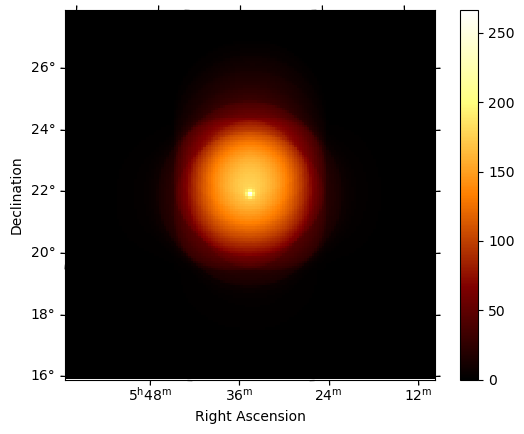

In [3]:
dataset_asimov = MapDataset.read("c:/users/yt02izug/downloads/dataset_asimov/dataset_asimov.fits")
# Create the spatial model 
model_spatial = GaussianSpatialModel(
    lon_0="83.631 deg",
    lat_0="22.018 deg",
    sigma="0.02 deg",
    )

# Create the spectral model 
model_spectrum  = ExpCutoffPowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",
    lambda_="0.1 TeV-1")

# combine the spectral and the spatial model
source_model = SkyModel(spatial_model = model_spatial ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)

# Create the model for the Background
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)

# set the models in the dataset
dataset_asimov.models = models
# set counts
dataset_asimov.counts = dataset_asimov.npred()
    
dataset_asimov.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_asimov.geoms["geom"].width[1] / dataset_asimov.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_asimov)

## Cases with varied Amplitude

In [4]:
amplitude_array = [1e-13, 5e-13, 1e-12, 5e-12]

sigma_spatial = 0.02

shift_neg = 0.0 #0.1 #0.085
tilt_neg = 0.0 #0.015

sigma_shift = 0.1
sigma_tilt = 0.015

In [5]:
#initialize asimov datasets with different amplitude
dataset_asimov_array = []
true_energy_array = []
datasets = []
datasets_N = []
for i, a in enumerate(amplitude_array):
    dataset_asimov = MapDataset.read("c:/users/yt02izug/downloads/dataset_asimov/dataset_asimov.fits")
    # Create the spatial model 
    model_spatial = GaussianSpatialModel(
        lon_0="83.631 deg",
        lat_0="22.018 deg",
        sigma=f"{sigma_spatial} deg",
        )

    # Create the spectral model 
    model_spectrum  = ExpCutoffPowerLawSpectralModel(
        index=2.3,
        amplitude=f"{a} TeV-1 cm-2 s-1",
        lambda_="0.1 TeV-1"
    )

    # combine the spectral and the spatial model
    source_model = SkyModel(spatial_model = model_spatial ,
                           spectral_model = model_spectrum,
                           name = "Source")    
    models = Models(source_model)

    # Create the model for the Background
    bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
    bkg_model.parameters['tilt'].frozen  = False
    models.append(bkg_model)

    # set the models in the dataset
    dataset_asimov.models = models
    # set counts
    dataset_asimov.counts = dataset_asimov.npred()
    
    dataset_asimov_array.append(dataset_asimov)
    
    sys_ = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = shift_neg, 
                        tilt = tilt_neg,
                        rnd = False,
                        amplitude = a,
                        sigma = sigma_spatial)
    dataset = sys_.create_dataset()
    dataset.models[0].parameters['lon_0'].frozen = True
    dataset.models[0].parameters['lat_0'].frozen = True
    datasets.append(dataset)
    
    dataset_N = sys_.create_dataset_N()
    zero = 1e-24
    ## additional parameter bias and resolution (ereco) but are frozen
    penalising_invcovmatrix = np.zeros((4, 4))
    np.fill_diagonal(penalising_invcovmatrix,
                     [1/sigma_shift**2, 1/sigma_tilt**2, 1/zero**2, 1/zero**2])
    dataset_N.penalising_invcovmatrix = penalising_invcovmatrix
    dataset_N.models[0].parameters['lon_0'].frozen = True
    dataset_N.models[0].parameters['lat_0'].frozen = True
    datasets_N.append(dataset_N)
    
    
    true_energy_array.append(dataset_asimov.exposure.geom.axes[0].center.value)

In [6]:
%%time
for i, a in enumerate(amplitude_array):
    print(a)
    fit = Fit(store_trace=False)
    minuit_opts = {"tol": 0.001, "strategy": 2}
    fit.backend = "minuit"
    fit.optimize_opts = minuit_opts
    result = fit.run([datasets[i]])

1e-13
5e-13
1e-12
5e-12
CPU times: total: 11.2 s
Wall time: 11.2 s


In [7]:
%%time
for i, a in enumerate(amplitude_array):
    print(a)
    fit_N = Fit(store_trace=False)
    minuit_opts = {"tol": 0.001, "strategy": 2}
    fit_N.backend = "minuit"
    fit_N.optimize_opts = minuit_opts
    result_N = fit_N.run([datasets_N[i]])

1e-13
5e-13
1e-12
5e-12
CPU times: total: 1h 17min 49s
Wall time: 12min 41s


# Stat Profiles

In [8]:
import upper_limit_18_02

## Stat Profiles for BKG Norm

In [9]:
def make_writable(stat):
    write = dict()
    for k in stat.keys():
        if k != 'fit_results':
            write[k] = [float(i) for i in stat[k]]
            
                
    return write

In [10]:
%%time
computing_norm = False
for i, a in enumerate(amplitude_array):
    print(a)
    if computing_norm :
        parameter = datasets[i].models[1].parameters['norm']
        sigma = 3
        parameter.scan_n_sigma  = sigma
        stat_profile = fit.stat_profile([datasets[i]], parameter, reoptimize= True)
        stat_profile['scale_scan'] = stat_profile.pop(next(iter(stat_profile)) )    
        with open(f'data/5b_scan_norm_A{a}_zero.yaml', 'w') as file:
            documents = yaml.dump(make_writable(stat_profile), file)
    else:
        with open(f'data/5b_scan_norm_A{a}_zero.yaml') as file:
            stat_profile = yaml.load( file, Loader=yaml.FullLoader)   

1e-13
5e-13
1e-12
5e-12
CPU times: total: 15.6 ms
Wall time: 12 ms


In [11]:
%%time
for i, a in enumerate(amplitude_array):
    print(a)
    if computing_norm :
        parameter = datasets_N[i].models[1].parameters['norm']
        sigma = 3
        parameter.scan_n_sigma  = sigma
        stat_profile_N = fit.stat_profile([datasets_N[i]], parameter, reoptimize = True)
        stat_profile_N['scale_scan'] = stat_profile_N.pop(next(iter(stat_profile_N)) )    
        with open(f'data/5b_scan_norm_N_A{a}_zero.yaml', 'w') as file:
            documents = yaml.dump(make_writable(stat_profile_N), file)
        for k in stat_profile_N:
            if "spectral" in k:
                key_name = "scale_scan"
                stat_profile_N[key_name] = stat_profile_N[k]      
    else:
        with open(f'data/5b_scan_norm_N_A{a}_zero.yaml') as file:
            stat_profile_N = yaml.load( file, Loader=yaml.FullLoader)
    

1e-13
5e-13
1e-12
5e-12
CPU times: total: 15.6 ms
Wall time: 12 ms


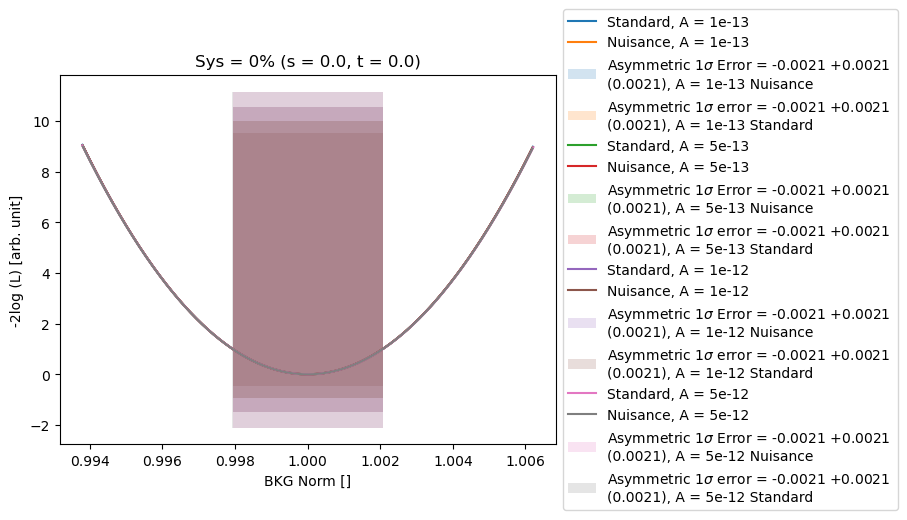

In [38]:
import upper_limit_18_02
fig = plt.figure()
for i, a in enumerate(amplitude_array):
    with open(f'data/5b_scan_norm_N_A{a}_zero.yaml') as file:
            stat_profile_N = yaml.load( file, Loader=yaml.FullLoader)
    ll_N = stat_profile_N.copy()
    ul_N = upper_limit_18_02.upper_limit(ll_N,0,0)
    L_N, x_N = ul_N.interpolate()
    plt.plot(x_N, L_N(x_N)-min(L_N(x_N)),label =f"Standard, A = {a}")
    
    with open(f'data/5b_scan_norm_A{a}_zero.yaml') as file:
            stat_profile = yaml.load( file, Loader=yaml.FullLoader)
    ll = stat_profile.copy()
    ul = upper_limit_18_02.upper_limit(ll,0,0)
    L, x = ul.interpolate()
    plt.plot(x, L(x)-min(L(x)),label =f"Nuisance, A = {a}")

    norm_err_N = datasets_N[i].models.parameters['norm'].error
    norm_err = datasets[i].models.parameters['norm'].error


#    min_, er = ul_N.likelihood_error()
#    min_ = min_[0]; er = er[0]
#    ax = plt.gca()
#    ylim= ax.get_ylim()
#    ax.fill_between(  [min_-er, min_+ er], ylim[0], ylim[1], alpha = 0.2, 
#                    label = f'1$\sigma$ error = {er:.2} ({norm_err_N:.2}), A = {a}')
#    min_, er = ul.likelihood_error() #min_, er, upp = ul.likelihood_upper()
#    min_ = min_[0]; er = er[0]
#    ax.fill_between(  [min_-er, min_+ er], ylim[0], ylim[1],  alpha = 0.2, 
#                    label = f'1$\sigma$ error = {er:.2} ({norm_err:.2}), A = {a}')
    
    min_, er_neg, er_pos = ul_N.likelihood_error_asymmetric()
    min_ = min_[0]; er_neg = er_neg[0]; er_pos = er_pos[0]; 
    ax = plt.gca()
    ylim= ax.get_ylim()
    ax.fill_between(  [min_-er_neg, min_+ er_pos], ylim[0], ylim[1], alpha = 0.2, 
                    label = f'Asymmetric 1$\sigma$ Error = -{er_neg:.2} +{er_pos:.2} \n({norm_err_N:.2}), A = {a} Nuisance')
    min_, er_neg, er_pos = ul.likelihood_error_asymmetric()
    min_ = min_[0]; er_neg = er_neg[0]; er_pos = er_pos[0]; 
    ax.fill_between(  [min_-er_neg, min_+ er_pos], ylim[0], ylim[1],  alpha = 0.2, 
                    label = f'Asymmetric 1$\sigma$ error = -{er_neg:.2} +{er_pos:.2} \n({norm_err:.2}), A = {a} Standard')

plt.xlabel("BKG Norm []")
plt.ylabel("-2log (L) [arb. unit]")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.ylim(ylim[0], ylim[1]-4)
plt.title(f"Sys = 0% (s = {shift_neg}, t = {tilt_neg})")

fig.savefig("plots/5b_stat_scan_norm_zero.png")

In [13]:
L_N(x_N)

array([-773102.31726675, -773102.3293347 , -773102.34139455, ...,
       -773102.41833486, -773102.40642949, -773102.39451623])

## Stat Profiles for Source Signal

In [14]:
%%time
computing_amplitude = False
for i, a in enumerate(amplitude_array):
    print(a)
    if computing_amplitude:
        sigma = 3
        parameter_a = datasets[i].models.parameters['amplitude']
        parameter_a.scan_n_sigma = sigma
        stat_profile_a = fit.stat_profile([datasets[i]], parameter_a, reoptimize= True)
        stat_profile_a['scale_scan'] = stat_profile_a.pop(next(iter(stat_profile_a)) )    
        with open(f'data/5b_scan_amplitude_A{a}_zero.yaml', 'w') as file:
            documents = yaml.dump(make_writable(stat_profile_a), file)

    else:
        with open(f'data/5b_scan_amplitude_A{a}_zero.yaml') as file:
            stat_profile_a = yaml.load( file, Loader=yaml.FullLoader)

    
    

1e-13
5e-13
1e-12
5e-12
CPU times: total: 15.6 ms
Wall time: 10 ms


In [15]:
%%time
computing_amplitude_N = False
for i, a in enumerate(amplitude_array):
    print(a)
    if computing_amplitude_N:
        sigma = 3
        parameter_a = datasets_N[i].models.parameters['amplitude']
        parameter_a.scan_n_sigma = sigma
        stat_profile_N_a = fit.stat_profile([datasets_N[i]], parameter_a, reoptimize = True)
        stat_profile_N_a['scale_scan'] = stat_profile_N_a.pop(next(iter(stat_profile_N_a)) )    

        with open(f'data/5b_scan_amplitude_N_A{a}_zero.yaml', 'w') as file:
            documents = yaml.dump(make_writable(stat_profile_N_a), file)

    else:
        with open(f'data/5b_scan_amplitude_N_A{a}_zero.yaml') as file:
            stat_profile_N_a = yaml.load( file, Loader=yaml.FullLoader)




1e-13
5e-13
1e-12
5e-12
CPU times: total: 15.6 ms
Wall time: 10 ms


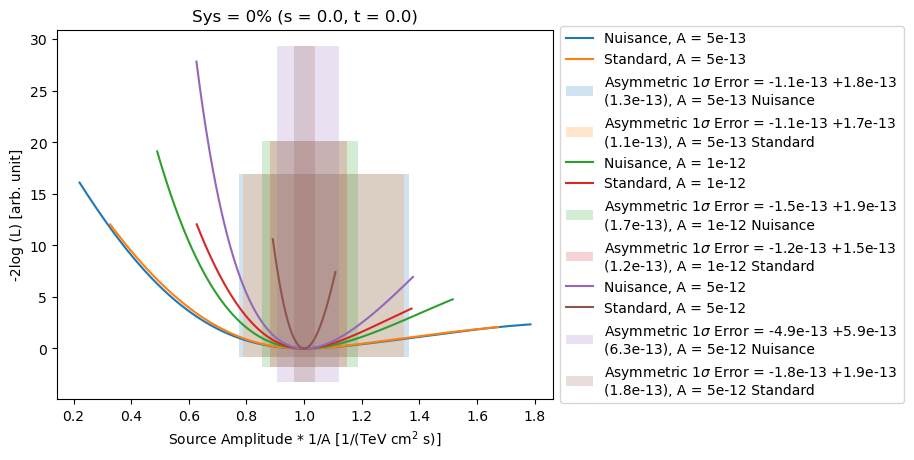

In [34]:
fig = plt.figure()
start = 1
for i, a in enumerate(amplitude_array[start:]):
    with open(f'data/5b_scan_amplitude_N_A{a}_zero.yaml') as file:
            stat_profile_N_a = yaml.load( file, Loader=yaml.FullLoader)
    ll_N_a = stat_profile_N_a.copy()
    ul_N_a = upper_limit_18_02.upper_limit(ll_N_a,0,0)
    L_N_a, x_N_a = ul_N_a.interpolate()
    plt.plot(x_N_a*a**(-1), L_N_a(x_N_a)-min(L_N_a(x_N_a)),label = f"Nuisance, A = {a}")

    with open(f'data/5b_scan_amplitude_A{a}_zero.yaml') as file:
            stat_profile_a = yaml.load( file, Loader=yaml.FullLoader)
    ll_a = stat_profile_a.copy()
    ul_a = upper_limit_18_02.upper_limit(ll_a,0,0)
    L_a, x_a = ul_a.interpolate()
    plt.plot(x_a*a**(-1), L_a(x_a)-min(L_a(x_a)),label = f"Standard, A = {a}")

    amplitude_err = datasets[i+start].models[0].parameters['amplitude'].error
    amplitude_err_N = datasets_N[i+start].models[0].parameters['amplitude'].error



#    min_, er = ul_N_a.likelihood_error()
#    min_ = min_[0]; er = er[0]
#    ax = plt.gca()
#    ylim= ax.get_ylim()
#    ax.fill_between(  [(min_-er)*a**(-1), (min_+ er)*a**(-1)], ylim[0], ylim[1], alpha = 0.2, 
#                    label = f'1$\sigma$ error = {er:.2} ({amplitude_err_N:.2}), A = {a} 1/(TeV cm$^2$ s)')
#    min_, er = ul_a.likelihood_error() #min_, er, upp = ul.likelihood_upper()
#    min_ = min_[0]; er = er[0]
#    ax.fill_between(  [(min_-er)*a**(-1), (min_+ er)*a**(-1)], ylim[0], ylim[1],  alpha = 0.2, 
#                    label = f'1$\sigma$ error = {er:.2} ({amplitude_err:.2}), A = {a} 1/(TeV cm$^2$ s)')
    
    min_, er_neg, er_pos = ul_N_a.likelihood_error_asymmetric()
    min_ = min_[0]; er_neg = er_neg[0]; er_pos = er_pos[0]; 
    ax = plt.gca()
    ylim= ax.get_ylim()
    ax.fill_between(  [(min_-er_neg)*a**(-1), (min_+ er_pos)*a**(-1)], ylim[0], ylim[1], alpha = 0.2, 
                    label = f'Asymmetric 1$\sigma$ Error = -{er_neg:.2} +{er_pos:.2} \n({amplitude_err_N:.2}), A = {a} Nuisance')
    min_, er_neg, er_pos = ul_a.likelihood_error_asymmetric()
    min_ = min_[0]; er_neg = er_neg[0]; er_pos = er_pos[0]; 
    ax.fill_between(  [(min_-er_neg)*a**(-1), (min_+ er_pos)*a**(-1)], ylim[0], ylim[1],  alpha = 0.2, 
                    label = f'Asymmetric 1$\sigma$ Error = -{er_neg:.2} +{er_pos:.2} \n({amplitude_err:.2}), A = {a} Standard')

plt.xlabel("Source Amplitude * 1/A [1/(TeV cm$^2$ s)]")
plt.ylabel("-2log (L) [arb. unit]")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.ylim(ylim[0], ylim[1]-25)
plt.title(f"Sys = 0% (s = {shift_neg}, t = {tilt_neg})")

fig.savefig("plots/5b_stat_scan_amplitude_zero.png")

## Stat Profiles for Source Index

In [17]:
%%time
computing_index = False

for i, a in enumerate(amplitude_array):
    print(a)
    if computing_index:
        sigma = 3
        parameter_i = datasets[i].models.parameters['index']
        parameter_i.scan_n_sigma = sigma
        stat_profile_i = fit.stat_profile([datasets[i]], parameter_i, reoptimize= True)
        stat_profile_i['scale_scan'] = stat_profile_i.pop(next(iter(stat_profile_i)) )    
        with open(f'data/5b_scan_index_A{a}_zero.yaml', 'w') as file:
            documents = yaml.dump(make_writable(stat_profile_i), file)

    else:
        with open(f'data/5b_scan_index_A{a}_zero.yaml') as file:
            stat_profile_i = yaml.load( file, Loader=yaml.FullLoader)

    
    

1e-13
5e-13
1e-12
5e-12
CPU times: total: 15.6 ms
Wall time: 18 ms


In [18]:
%%time
computing_index_N = False
for i, a in enumerate(amplitude_array):
    print(a)
    if computing_index_N:
        sigma = 3
        parameter_i = datasets_N[i].models.parameters['index']
        parameter_i.scan_n_sigma = sigma
        stat_profile_N_i = fit.stat_profile([datasets_N[i]], parameter_i, reoptimize = True)
        stat_profile_N_i['scale_scan'] = stat_profile_N_i.pop(next(iter(stat_profile_N_i)) )    

        with open(f'data/5b_scan_index_N_A{a}_zero.yaml', 'w') as file:
            documents = yaml.dump(make_writable(stat_profile_N_i), file)

    else:
        with open(f'data/5b_scan_index_N_A{a}_zero.yaml') as file:
            stat_profile_N_i = yaml.load( file, Loader=yaml.FullLoader)

    
    

1e-13
5e-13
1e-12
5e-12
CPU times: total: 0 ns
Wall time: 12 ms


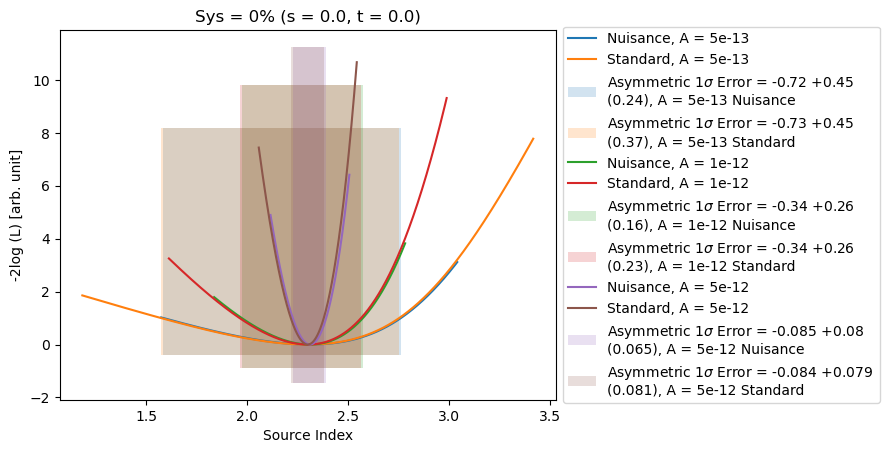

In [35]:
fig = plt.figure()
start = 1
for i, a in enumerate(amplitude_array[start:]):
    with open(f'data/5b_scan_index_N_A{a}_zero.yaml') as file:
            stat_profile_N_i = yaml.load( file, Loader=yaml.FullLoader)
    ll_N_a = stat_profile_N_i.copy()
    ul_N_a = upper_limit_18_02.upper_limit(ll_N_a,0,0)
    L_N_a, x_N_a = ul_N_a.interpolate()
    plt.plot(x_N_a, L_N_a(x_N_a)-min(L_N_a(x_N_a)),label = f"Nuisance, A = {a}")

    with open(f'data/5b_scan_index_A{a}_zero.yaml') as file:
            stat_profile_i = yaml.load( file, Loader=yaml.FullLoader)
    ll_a = stat_profile_i.copy()
    ul_a = upper_limit_18_02.upper_limit(ll_a,0,0)
    L_a, x_a = ul_a.interpolate()
    plt.plot(x_a, L_a(x_a)-min(L_a(x_a)),label = f"Standard, A = {a}")

    index_err = datasets[i+start].models[0].parameters['index'].error
    index_err_N = datasets_N[i+start].models[0].parameters['index'].error



#    min_, er = ul_N_a.likelihood_error()
#    min_ = min_[0]; er = er[0]
#    ax = plt.gca()
#    ylim= ax.get_ylim()
#    ax.fill_between(  [min_-er, min_+ er], ylim[0], ylim[1], alpha = 0.2, 
#                    label = f'1$\sigma$ error = {er:.2} ({index_err_N:.2}), A = {a}')
#    min_, er = ul_a.likelihood_error() #min_, er, upp = ul.likelihood_upper()
#    min_ = min_[0]; er = er[0]
#    ax.fill_between(  [min_-er, min_+ er], ylim[0], ylim[1],  alpha = 0.2, 
#                    label = f'1$\sigma$ error = {er:.2} ({index_err:.2}), A = {a}')
    
    min_, er_neg, er_pos = ul_N_a.likelihood_error_asymmetric()
    min_ = min_[0]; er_neg = er_neg[0]; er_pos = er_pos[0]; 
    ax = plt.gca()
    ylim= ax.get_ylim()
    ax.fill_between(  [min_-er_neg, min_+ er_pos], ylim[0], ylim[1], alpha = 0.2, 
                    label = f'Asymmetric 1$\sigma$ Error = -{er_neg:.2} +{er_pos:.2} \n({index_err_N:.2}), A = {a} Nuisance')
    min_, er_neg, er_pos = ul_a.likelihood_error_asymmetric()
    min_ = min_[0]; er_neg = er_neg[0]; er_pos = er_pos[0]; 
    ax.fill_between(  [min_-er_neg, min_+ er_pos], ylim[0], ylim[1],  alpha = 0.2, 
                    label = f'Asymmetric 1$\sigma$ Error = -{er_neg:.2} +{er_pos:.2} \n({index_err:.2}), A = {a} Standard')

plt.xlabel("Source Index")
plt.ylabel("-2log (L) [arb. unit]")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.ylim(ylim[0], ylim[1]-25)
plt.title(f"Sys = 0% (s = {shift_neg}, t = {tilt_neg})")

fig.savefig("plots/5b_stat_scan_index_zero.png")

## Stat Profiles for Source Lambda

In [18]:
scan_array = np.append(np.linspace(0.01, 0.5, 11), datasets_N[i].models[0].parameters['lambda_'].value)
print(scan_array)
scan_array.sort()
print(scan_array)

[0.01       0.059      0.108      0.157      0.206      0.255
 0.304      0.353      0.402      0.451      0.5        0.09840811]
[0.01       0.059      0.09840811 0.108      0.157      0.206
 0.255      0.304      0.353      0.402      0.451      0.5       ]


In [19]:
%%time
computing_lambda = False

for i, a in enumerate(amplitude_array):
    print(a)
    if computing_lambda:
        sigma = 3
        scan_array = np.append(np.linspace(0.01, 0.5, 11), datasets[i].models[0].parameters['lambda_'].value)
        scan_array.sort()
        parameter_l = datasets[i].models.parameters['lambda_']
        parameter_l.scan_values = scan_array#scan_n_sigma = sigma
        stat_profile_l = fit.stat_profile([datasets[i]], parameter_l, reoptimize= True)
        stat_profile_l['scale_scan'] = stat_profile_l.pop(next(iter(stat_profile_l)) )    
        with open(f'data/5b_scan_lambda_A{a}_zero.yaml', 'w') as file:
            documents = yaml.dump(make_writable(stat_profile_l), file)

    else:
        with open(f'data/5b_scan_lambda_A{a}_zero.yaml') as file:
            stat_profile_l = yaml.load( file, Loader=yaml.FullLoader)

1e-13
5e-13
1e-12
5e-12
CPU times: total: 4min 2s
Wall time: 4min 3s


In [11]:
%%time
computing_lambda_N = False
for i, a in enumerate(amplitude_array):
    print(a)
    if computing_lambda_N:
        sigma = 3
        scan_array = np.append(np.linspace(0.01, 0.5, 11), datasets_N[i].models[0].parameters['lambda_'].value)
        scan_array.sort()
        parameter_l = datasets_N[i].models.parameters['lambda_']
        parameter_l.scan_values = scan_array#scan_n_sigma = sigma
        stat_profile_N_l = fit.stat_profile([datasets_N[i]], parameter_l, reoptimize = True)
        stat_profile_N_l['scale_scan'] = stat_profile_N_l.pop(next(iter(stat_profile_N_l)) )    

        with open(f'data/5b_scan_lambda_N_A{a}_zero.yaml', 'w') as file:
            documents = yaml.dump(make_writable(stat_profile_N_l), file)

    else:
        with open(f'data/5b_scan_lambda_N_A{a}_zero.yaml') as file:
            stat_profile_N_l = yaml.load( file, Loader=yaml.FullLoader)


1e-13
5e-13


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encoun

1e-12
5e-12
CPU times: total: 16h 26min 17s
Wall time: 2h 24min 21s


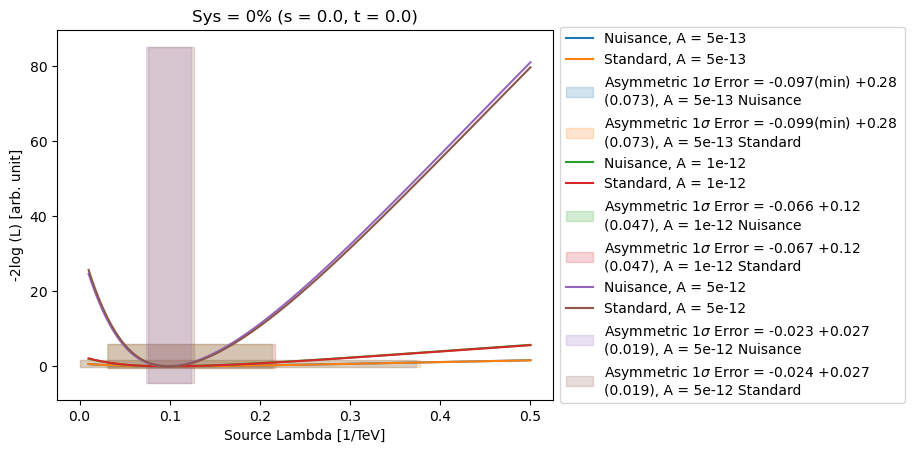

In [20]:
fig = plt.figure()
start = 1
color_array = [['tab:olive', 'tab:cyan'], ['tab:orange', 'tab:blue'], ['tab:red', 'tab:green'], ['tab:brown', 'tab:purple']]
for i, a in enumerate(amplitude_array[start:]):
    with open(f'data/5b_scan_lambda_N_A{a}_zero.yaml') as file:
            stat_profile_N_l = yaml.load( file, Loader=yaml.FullLoader)
    ll_N_a = stat_profile_N_l.copy()
    ul_N_a = upper_limit_18_02.upper_limit(ll_N_a,0,0)
    L_N_a, x_N_a = ul_N_a.interpolate()
    plt.plot(x_N_a, L_N_a(x_N_a)-min(L_N_a(x_N_a)),label = f"Nuisance, A = {a}", color = color_array[i+start][1])

    with open(f'data/5b_scan_lambda_A{a}_zero.yaml') as file:
            stat_profile_l = yaml.load( file, Loader=yaml.FullLoader)
    ll_a = stat_profile_l.copy()
    ul_a = upper_limit_18_02.upper_limit(ll_a,0,0)
    L_a, x_a = ul_a.interpolate()
    plt.plot(x_a, L_a(x_a)-min(L_a(x_a)),label = f"Standard, A = {a}", color = color_array[i+start][0])

    lambda_err = datasets[i+start].models[0].parameters['lambda_'].error
    lambda_err_N = datasets_N[i+start].models[0].parameters['lambda_'].error



#    min_, er = ul_N_a.likelihood_error()
#    min_ = min_[0]; er = er[0]
#    ax = plt.gca()
#    ylim= ax.get_ylim()
#    ax.fill_between(  [min_-er, min_+ er], ylim[0], ylim[1], alpha = 0.2, 
#                    label = f'1$\sigma$ error = {er:.2} ({lambda_err_N:.2}), A = {a}', color = color_array[i+start][1])
#    min_, er = ul_a.likelihood_error() #min_, er, upp = ul.likelihood_upper()
#    min_ = min_[0]; er = er[0]
#    ax.fill_between(  [min_-er, min_+ er], ylim[0], ylim[1],  alpha = 0.2, 
#                    label = f'1$\sigma$ error = {er:.2} ({lambda_err:.2}), A = {a}', color = color_array[i+start][0])
    
    min_, er_neg, er_pos = ul_N_a.likelihood_error_asymmetric()
    min_ = min_[0]; er_neg = er_neg[0]; er_pos = er_pos[0];
    ax = plt.gca()
    ylim= ax.get_ylim()
    if er_neg < 0:
         ax.fill_between(  [0, min_+er_pos], ylim[0], ylim[1], alpha = 0.2, 
                        label = f'Asymmetric 1$\sigma$ Error = -{min_:.2}(min) +{er_pos:.2} \n({lambda_err_N:.2}), A = {a} Nuisance', color = color_array[i+start][1])
    else:
        ax.fill_between(  [min_-er_neg, min_+er_pos], ylim[0], ylim[1], alpha = 0.2, 
                        label = f'Asymmetric 1$\sigma$ Error = -{er_neg:.2} +{er_pos:.2} \n({lambda_err_N:.2}), A = {a} Nuisance', color = color_array[i+start][1])
    min_, er_neg, er_pos = ul_a.likelihood_error_asymmetric()
    min_ = min_[0]; er_neg = er_neg[0]; er_pos = er_pos[0];
    if er_neg < 0:
         ax.fill_between(  [0, min_+er_pos], ylim[0], ylim[1], alpha = 0.2, 
                        label = f'Asymmetric 1$\sigma$ Error = -{min_:.2}(min) +{er_pos:.2} \n({lambda_err_N:.2}), A = {a} Standard', color = color_array[i+start][0])
    else:
        ax.fill_between(  [min_-er_neg, min_+er_pos], ylim[0], ylim[1], alpha = 0.2, 
                        label = f'Asymmetric 1$\sigma$ Error = -{er_neg:.2} +{er_pos:.2} \n({lambda_err_N:.2}), A = {a} Standard', color = color_array[i+start][0])
    #ul_N_a.plot_interpolate()
    #ul_a.plot_interpolate()
plt.xlabel("Source Lambda [1/TeV]")
plt.ylabel("-2log (L) [arb. unit]")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.ylim(ylim[0], ylim[1]-25)
plt.title(f"Sys = 0% (s = {shift_neg}, t = {tilt_neg})")

fig.savefig("plots/5b_stat_scan_lambda_zero.png")

## Penalty Examples

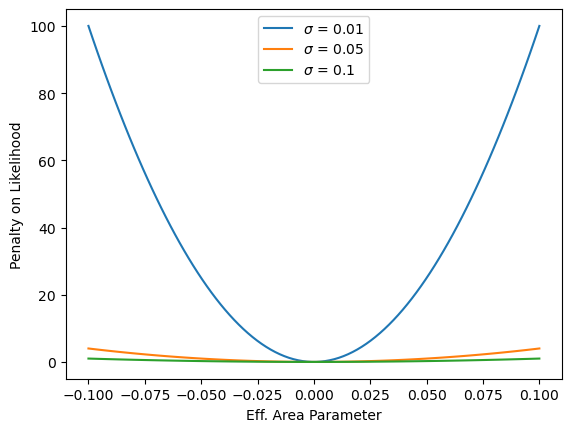

In [23]:
ps = [1e-2, 0.05, 0.1]
plot_values = np.linspace(-0.1, 0.1, 100)
for p in ps:
    plt.plot(plot_values, plot_values ** 2 / p ** 2, label = "$\sigma$ = "+ str(p)) 
plt.legend()

plt.ylabel('Penalty on Likelihood')    
plt.xlabel('Eff. Area Parameter')
fig  = plt.gcf()
fig.savefig('plots/5b_gaussian_penalty_example.pdf')

### Calculating Delta TS

In [24]:
Value = 0.0

In [25]:
%%time
computing_amplitude = False
for i, a in enumerate(amplitude_array):
    print(a)
    if computing_amplitude:
        sigma = 3
        parameter_a = datasets[i].models.parameters['amplitude']
        parameter_a.scan_values = [Value]
        stat_profile_a = fit.stat_profile([datasets[i]], parameter_a, reoptimize= True)
        stat_profile_a['scale_scan'] = stat_profile_a.pop(next(iter(stat_profile_a)) )    
        with open(f'data/5b_scan_amplitude_at_zero_A{a}_zero.yaml', 'w') as file:
            documents = yaml.dump(make_writable(stat_profile_a), file)

    

1e-13
5e-13
1e-12
5e-12
CPU times: total: 0 ns
Wall time: 0 ns


In [26]:
%%time
computing_amplitude_N = False
for i, a in enumerate(amplitude_array):
    print(a)
    if computing_amplitude_N:
        sigma = 3
        parameter_a = datasets_N[i].models.parameters['amplitude']
        parameter_a.scan_values = [Value]
        stat_profile_N_a = fit.stat_profile([datasets_N[i]], parameter_a, reoptimize = True)
        stat_profile_N_a['scale_scan'] = stat_profile_N_a.pop(next(iter(stat_profile_N_a)) )    

        with open(f'data/5b_scan_amplitude_at_zero_N_A{a}_zero.yaml', 'w') as file:
            documents = yaml.dump(make_writable(stat_profile_N_a), file)


1e-13
5e-13
1e-12
5e-12
CPU times: total: 0 ns
Wall time: 0 ns


In [27]:
from numpy import savetxt
deltats = []
for i, a in enumerate(amplitude_array):
    with open(f'data/5b_scan_amplitude_at_zero_A{a}_zero.yaml') as file:
                stat_profile_a_0 = yaml.load( file, Loader=yaml.FullLoader)
    with open(f'data/5b_scan_amplitude_A{a}_zero.yaml') as file:
            stat_profile_a = yaml.load( file, Loader=yaml.FullLoader)
    #print(min(stat_profile_a['stat_scan']))
    b = min(stat_profile_a_0['stat_scan']) - min(stat_profile_a['stat_scan'])
    print(a, np.sqrt(b))
    deltats.append(np.sqrt(b))
np.savetxt(f'data/5b_significance_zero.txt', [amplitude_array, deltats])

1e-13 0.005490355303371301
5e-13 6.8763753193863195
1e-12 13.347460565976034
5e-12 56.86028871396425


In [33]:
deltats_N = []
for i, a in enumerate(amplitude_array):
    with open(f'data/5b_scan_amplitude_at_zero_N_A{a}_zero.yaml') as file:
                stat_profile_N_a_0 = yaml.load( file, Loader=yaml.FullLoader)
    with open(f'data/5b_scan_amplitude_N_A{a}_zero.yaml') as file:
            stat_profile_N_a = yaml.load( file, Loader=yaml.FullLoader)
    #print(min(stat_profile_a['stat_scan']))
    b = min(stat_profile_N_a_0['stat_scan']) - min(stat_profile_N_a['stat_scan'])
    print(a, np.sqrt(b))
    deltats_N.append(np.sqrt(b))
np.savetxt(f'data/5b_significance_N_A_zero.txt', [amplitude_array, deltats_N])

1e-13 0.9351606247989007
5e-13 6.874467605710007
1e-12 13.345172587167443
5e-12 56.859270557111444


In [29]:
from scipy.optimize import curve_fit
from scipy import interpolate
def parabola(x, a, b, c):
    y = a * (x-c)**2 + b
    return y

5e-13
5.048541250773921
1e-12
7.859049785797003
5e-12
12.038774099573414


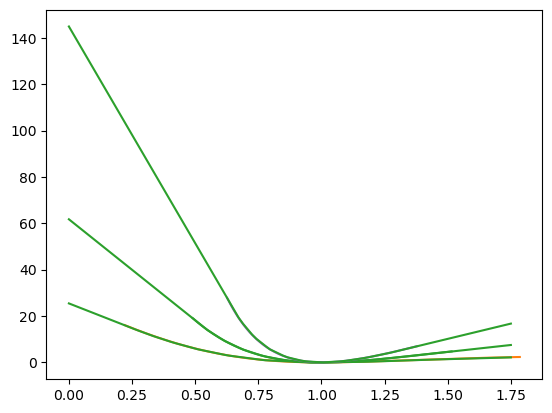

In [30]:
parameter_array = []
parameter_N_array = []
start = 1
for i, a in enumerate(amplitude_array[start:]):
    print(a)
    with open(f'data/5b_scan_amplitude_N_A{a}_zero.yaml') as file:
            stat_profile_N_a = yaml.load( file, Loader=yaml.FullLoader)
    ll_N_a = stat_profile_N_a.copy()
    ul_N_a = upper_limit_18_02.upper_limit(ll_N_a,0,0)
    L_N_a, x_N_a = ul_N_a.interpolate()
    plt.plot(x_N_a*a**(-1), L_N_a(x_N_a)-min(ll_N_a['stat_scan']), label = f"Nuisance, A = {a}", color = color_array[i+start][0])
    
    f = interpolate.interp1d(ll_N_a['scale_scan'],  ll_N_a['stat_scan'], fill_value = 'extrapolate')
    print(np.sqrt(f(0.0)-min(ll_N_a['stat_scan'])))
    x_n = np.linspace(0, 1.75, 100)
    #plt.ylim(-750000, -748000)
    plt.plot(x_n, f(x_n*a)-f(a), label = f'Parabola Fit, A = {a}', color = 'tab:green')
#     with open(f'data/5b_scan_amplitude_A{a}_zero.yaml') as file:
#             stat_profile_a = yaml.load( file, Loader=yaml.FullLoader)
#     ll_a = stat_profile_a.copy()
#     ul_a = upper_limit_18_02.upper_limit(ll_a,0,0)
#     L_a, x_a = ul_a.interpolate()
#     parameters, covariance = curve_fit(parabola, ll_a['scale_scan'], ll_a['stat_scan'])
#     parameter_array.append(parameters)
#     print(parameters)
#     print(np.sqrt(parabola(0.0, parameters[0], a, parameters[1], parameters[2])-min(ll_a['stat_scan'])))

5e-13
5.195122371753856
5.223390551698458
1e-12
10.061423314018551
10.01790609958695
5e-12
19.458609933720687
32.69534728591802


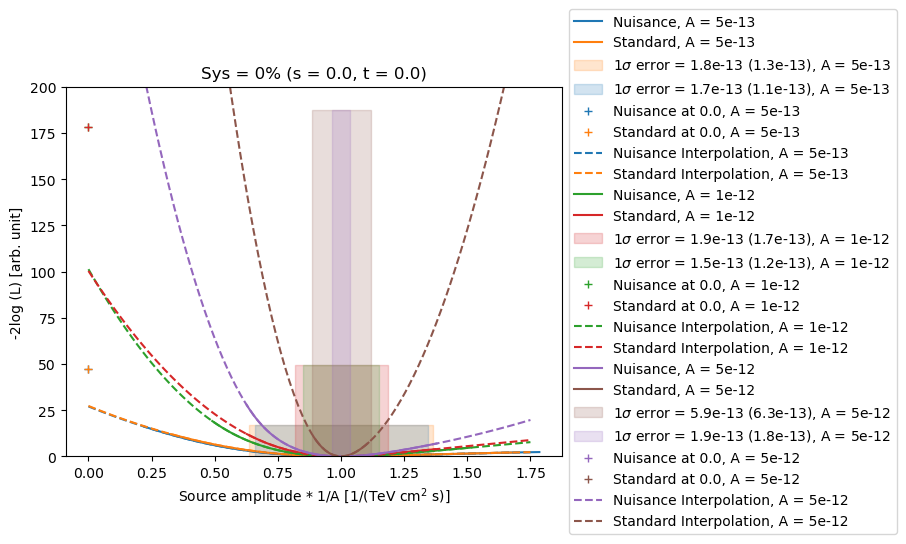

In [42]:
fig = plt.figure()
start = 1
color_array = [['tab:olive', 'tab:cyan'], ['tab:orange', 'tab:blue'], ['tab:red', 'tab:green'], ['tab:brown', 'tab:purple']]
for i, a in enumerate(amplitude_array[start:]):
    with open(f'data/5b_scan_amplitude_N_A{a}_zero.yaml') as file:
            stat_profile_N_a = yaml.load( file, Loader=yaml.FullLoader)
    ll_N_a = stat_profile_N_a.copy()
    ul_N_a = upper_limit_18_02.upper_limit(ll_N_a,0,0)
    L_N_a, x_N_a = ul_N_a.interpolate()
    plt.plot(x_N_a*a**(-1), L_N_a(x_N_a)-min(L_N_a(x_N_a)),label = f"Nuisance, A = {a}", color = color_array[i+start][1])

    with open(f'data/5b_scan_amplitude_A{a}_zero.yaml') as file:
            stat_profile_a = yaml.load( file, Loader=yaml.FullLoader)
    ll_a = stat_profile_a.copy()
    ul_a = upper_limit_18_02.upper_limit(ll_a,0,0)
    L_a, x_a = ul_a.interpolate()
    plt.plot(x_a*a**(-1), L_a(x_a)-min(L_a(x_a)),label = f"Standard, A = {a}", color = color_array[i+start][0])
    
    amplitude_err = datasets[i+start].models[0].parameters['amplitude'].error
    amplitude_err_N = datasets_N[i+start].models[0].parameters['amplitude'].error



    min_, er = ul_N_a.likelihood_error()
    min_ = min_[0]; er = er[0]
    ax = plt.gca()
    ylim= ax.get_ylim()
    ax.fill_between(  [(min_-er)*a**(-1), (min_+ er)*a**(-1)], ylim[0], ylim[1], alpha = 0.2, 
                    label = f'1$\sigma$ error = {er:.2} ({amplitude_err_N:.2}), A = {a}', color = color_array[i+start][0])
    min_, er = ul_a.likelihood_error() #min_, er, upp = ul.likelihood_upper()
    min_ = min_[0]; er = er[0]
    ax.fill_between(  [(min_-er)*a**(-1), (min_+ er)*a**(-1)], ylim[0], ylim[1],  alpha = 0.2, 
                    label = f'1$\sigma$ error = {er:.2} ({amplitude_err:.2}), A = {a}', color = color_array[i+start][1])
    
    with open(f'data/5b_scan_amplitude_at_zero_N_A{a}_zero.yaml') as file:
                stat_profile_N_a_0 = yaml.load( file, Loader=yaml.FullLoader)
    ll_N_a_0 = stat_profile_N_a_0.copy()
    plt.plot(ll_N_a_0['scale_scan'], ll_N_a_0['stat_scan']-min(L_N_a(x_N_a)), '+', label = f"Nuisance at {Value}, A = {a}", color = color_array[i+start][1])
    
    with open(f'data/5b_scan_amplitude_at_zero_A{a}_zero.yaml') as file:
                stat_profile_a_0 = yaml.load( file, Loader=yaml.FullLoader)
    ll_a_0 = stat_profile_a_0.copy()
    plt.plot(ll_a_0['scale_scan'], ll_a_0['stat_scan']-min(L_a(x_a)), '+', label = f"Standard at {Value}, A = {a}", color = color_array[i+start][0])
    
    print(a)
    f = interpolate.interp1d(ll_N_a['scale_scan'],  ll_N_a['stat_scan'], fill_value = 'extrapolate', kind = 'quadratic') #'cubic' in upper_limit...
    print(np.sqrt(f(0.0)-min(ll_N_a['stat_scan'])))
    x_n = np.linspace(0, 1.75, 100)
    plt.plot(x_n, f(x_n*a)-f(a), '--', label = f'Nuisance Interpolation, A = {a}', color = color_array[i+start][1])
    
    f = interpolate.interp1d(ll_a['scale_scan'],  ll_a['stat_scan'], fill_value = 'extrapolate', kind = 'quadratic')
    print(np.sqrt(f(0.0)-min(ll_a['stat_scan'])))
    plt.plot(x_n, f(x_n*a)-f(a), '--', label = f'Standard Interpolation, A = {a}', color = color_array[i+start][0])
    
plt.xlabel("Source amplitude * 1/A [1/(TeV cm$^2$ s)]")
plt.ylabel("-2log (L) [arb. unit]")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(0, 200)
plt.title(f"Sys = 0% (s = {shift_neg}, t = {tilt_neg})")

fig.savefig("plots/5b_stat_scan_amplitude_zero_with_zero.png")